,subject,timepoint,biomarker_0,biomarker_1,biomarker_2,biomarker_3,biomarker_4
0,1,0.000000,-0.033489,-0.052632,-0.045887,0.842935,0.738897
1,2,0.000000,0.096386,0.107866,0.043484,0.519497,0.711044
2,2,0.453224,0.153048,0.063080,0.205047,0.964920,1.079642
3,2,0.704842,0.773720,0.463185,0.535985,1.004168,1.086914
4,3,0.000000,-0.142374,0.065759,0.091800,0.542679,0.839803
...,...,...,...,...,...,...,...
96,44,0.000000,0.826585,0.652666,0.420267,0.904985,0.997973
97,44,0.043503,0.926362,0.629665,0.476902,1.079558,0.922526
98,44,0.096375,0.818533,0.802547,0.403630,0.922276,1.081844
99,47,0.000000,0.209007,0.263799,0.451081,0.947249,1.174377


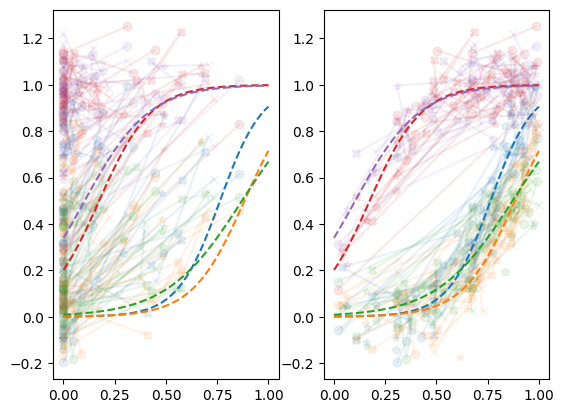

In [2]:
import json
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from fl_prog.utils.constants import DNAME_LATEST

np.set_printoptions(precision=3, suppress=True)

N_ROUNDS = 10
N_UPDATES = 70
BATCH_SIZE = 100000
LEARNING_RATE = 0.01

data_dir = Path(os.environ["DPATH_DATA"]) / DNAME_LATEST

json_data = json.loads((data_dir / "simulated_data.json").read_text())

n_biomarkers = json_data["settings"]["n_biomarkers"]
params = json_data["params"]
k_values = np.array(params["k_values"])
x0_values = np.array(params["x0_values"])
time_shifts = np.array(params["time_shifts"])

df = pd.read_csv(data_dir / "simulated_data-merged.tsv", sep="\t")
display(df)

fig, axes = plt.subplots(ncols=2)
for i_ax, ax in enumerate(axes):
    ax: plt.Axes

    for i_subject, (subject, df_subject) in enumerate(df.groupby("subject")):
        for i_biomarker, biomarker in enumerate(
            [f"biomarker_{i}" for i in range(n_biomarkers)]
        ):
            ax.plot(
                (
                    df_subject["timepoint"] + time_shifts[i_subject]
                    if i_ax == 1
                    else df_subject["timepoint"]
                ),
                df_subject[biomarker],
                marker="oXxp*"[i_subject % 5],
                color=f"C{i_biomarker}",
                alpha=0.1,
            )

    for i_biomarker, (k, x0) in enumerate(zip(k_values, x0_values)):
        t = np.linspace(0, 1, 100)
        y = 1 / (1 + np.exp(-k * (t - x0)))
        ax.plot(t, y, color=f"C{i_biomarker}", linestyle="--", alpha=1)


def check_model_fit(
    estimated_k_values, estimated_x0_values, estimated_time_shifts, align_x=False
):
    _, ax = plt.subplots()
    ax: plt.Axes

    x_value_differences = x0_values - estimated_x0_values

    for i_biomarker, (k, x0) in enumerate(zip(k_values, x0_values)):
        t = np.linspace(-1, 2, 100)
        y = 1 / (1 + np.exp(-k * (t - x0)))
        ax.plot(t, y, color=f"C{i_biomarker}", linestyle="--", alpha=0.8)

        y_pred = torch.sigmoid(
            torch.tensor(
                estimated_k_values[i_biomarker] * (t - estimated_x0_values[i_biomarker])
            )
        ).numpy()
        ax.plot(
            t + x_value_differences[i_biomarker] if align_x else t,
            y_pred,
            color=f"C{i_biomarker}",
            linestyle="-",
            alpha=0.8,
        )

    print("===== k values =====")
    print(k_values)
    print(estimated_k_values)
    print("===== x0 values =====")
    print(x0_values)
    print(estimated_x0_values)
    print("===== x value differences =====")
    print(x0_values - estimated_x0_values)
    print("===== time shifts =====")
    print(time_shifts)
    print(estimated_time_shifts)
    if len(estimated_time_shifts) > 0:
        print("===== time shift offset difference =====")
        if len(time_shifts) < len(estimated_time_shifts):
            warnings.warn(
                "Number of estimated time shifts is larger than the number of true time "
                "shifts. Clipping estimated time shifts."
            )
            estimated_time_shifts = estimated_time_shifts[: len(time_shifts)]

        print((time_shifts - estimated_time_shifts).std())

In [3]:
from fl_prog.utils.io import working_directory
from fl_prog.training_plan import FLProgTrainingPlan
from fl_prog.aggregator import SelectiveFedAverage

import importlib
import fl_prog.training_plan

importlib.reload(fl_prog.training_plan)
from fl_prog.training_plan import FLProgTrainingPlan


fedbiomed_dir = "../fedbiomed"
with working_directory(fedbiomed_dir):

    from fedbiomed.researcher.federated_workflows import Experiment
    from fedbiomed.researcher.aggregators.fedavg import FedAverage

    experiment = Experiment(
        nodes=["NODE_CENTRALIZED"],
        tags=["centralized"],
        training_plan_class=FLProgTrainingPlan,
        model_args={
            "colnames": {
                "col_subject_id": "subject",
                "col_time": "timepoint",
                "cols_biomarker": [f"biomarker_{i}" for i in range(n_biomarkers)],
            },
            "lr_with_shift": {
                "n_features": n_biomarkers,
            },
        },
        round_limit=N_ROUNDS,
        training_args={
            "num_updates": N_UPDATES,
            "loader_args": {"batch_size": BATCH_SIZE, "shuffle": False},
            "optimizer_args": {"lr": LEARNING_RATE},
        },
        aggregator=SelectiveFedAverage(["time_shifts"]),
        node_selection_strategy=None,
    )
    experiment.run()

/home/bic/mwang/projects/fl-prog/.venv/lib/python3.10/site-packages/monai/utils/module.py:367: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  pkg = __import__(module)  # top level module


2025-10-13 07:46:14,906 fedbiomed INFO - Starting researcher service...

2025-10-13 07:46:14,910 fedbiomed INFO - Waiting 3s for nodes to connect...

2025-10-13 07:46:16,835 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:17,920 fedbiomed INFO - Updating training data. This action will update FederatedDataset, and the nodes that will participate to the experiment.

2025-10-13 07:46:17,971 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:18,035 fedbiomed INFO - Node selected for training -> NODE_CENTRALIZED

<function extract_symbols at 0x7f920de88d30>


2025-10-13 07:46:18,117 fedbiomed DEBUG - Model file has been saved: /data/origami/michelle/projects/fl-prog/fedbiomed/fbm-researcher/var/experiments/Experiment_0117/model_ea4b7ed4-5d8d-4c61-834f-4932f271787c.py

Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.


2025-10-13 07:46:18,427 fedbiomed INFO - Sampled nodes in round 0 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f920de88d30>


2025-10-13 07:46:18,503 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-13 07:46:18,620 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:18,953 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: 506.942505 
					 ---------

2025-10-13 07:46:18,958 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: 504.566071 
					 ---------

2025-10-13 07:46:18,960 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: 502.192719 
					 ---------

2025-10-13 07:46:18,977 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: 499.822601 
					 ---------

2025-10-13 07:46:19,010 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: 497.455261 
					 ---------

2025-10-13 07:46:19,053 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: 495.090454 
					 ---------

2025-10-13 07:46:19,065 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: 492.727539 
					 ---------

2025-10-13 07:46:19,081 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: 490.366028 
					 ---------

2025-10-13 07:46:19,090 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: 488.004791 
					 ---------

2025-10-13 07:46:19,112 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: 485.642456 
					 ---------

2025-10-13 07:46:19,135 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: 483.277863 
					 ---------

2025-10-13 07:46:19,159 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: 480.909363 
					 ---------

2025-10-13 07:46:19,180 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: 478.535583 
					 ---------

2025-10-13 07:46:19,202 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: 476.154907 
					 ---------

2025-10-13 07:46:19,224 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: 473.765808 
					 ---------

2025-10-13 07:46:19,244 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: 471.367065 
					 ---------

2025-10-13 07:46:19,263 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: 468.957031 
					 ---------

2025-10-13 07:46:19,288 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: 466.534180 
					 ---------

2025-10-13 07:46:19,307 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: 464.096588 
					 ---------

2025-10-13 07:46:19,330 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: 461.642639 
					 ---------

2025-10-13 07:46:19,356 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: 459.170471 
					 ---------

2025-10-13 07:46:19,376 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: 456.677917 
					 ---------

2025-10-13 07:46:19,395 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: 454.163116 
					 ---------

2025-10-13 07:46:19,420 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: 451.623718 
					 ---------

2025-10-13 07:46:19,438 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: 449.057617 
					 ---------

2025-10-13 07:46:19,464 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: 446.462585 
					 ---------

2025-10-13 07:46:19,484 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: 443.836700 
					 ---------

2025-10-13 07:46:19,523 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: 441.177399 
					 ---------

2025-10-13 07:46:19,544 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: 438.482544 
					 ---------

2025-10-13 07:46:19,567 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: 435.750397 
					 ---------

2025-10-13 07:46:19,584 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: 432.979126 
					 ---------

2025-10-13 07:46:19,605 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: 430.167389 
					 ---------

2025-10-13 07:46:19,624 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: 427.313477 
					 ---------

2025-10-13 07:46:19,644 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: 424.416595 
					 ---------

2025-10-13 07:46:19,668 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: 421.476166 
					 ---------

2025-10-13 07:46:19,691 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: 418.492157 
					 ---------

2025-10-13 07:46:19,712 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: 415.464630 
					 ---------

2025-10-13 07:46:19,729 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: 412.393585 
					 ---------

2025-10-13 07:46:19,752 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: 409.279938 
					 ---------

2025-10-13 07:46:19,772 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: 406.125031 
					 ---------

2025-10-13 07:46:19,792 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: 402.930756 
					 ---------

2025-10-13 07:46:19,808 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: 399.699432 
					 ---------

2025-10-13 07:46:19,835 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: 396.434052 
					 ---------

2025-10-13 07:46:19,855 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: 393.137939 
					 ---------

2025-10-13 07:46:19,883 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: 389.814178 
					 ---------

2025-10-13 07:46:19,896 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: 386.466553 
					 ---------

2025-10-13 07:46:19,911 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: 383.098694 
					 ---------

2025-10-13 07:46:19,931 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: 379.714691 
					 ---------

2025-10-13 07:46:19,956 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: 376.318787 
					 ---------

2025-10-13 07:46:19,980 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: 372.915070 
					 ---------

2025-10-13 07:46:20,002 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: 369.508209 
					 ---------

2025-10-13 07:46:20,024 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: 366.102783 
					 ---------

2025-10-13 07:46:20,047 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: 362.701965 
					 ---------

2025-10-13 07:46:20,071 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: 359.309448 
					 ---------

2025-10-13 07:46:20,092 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: 355.928558 
					 ---------

2025-10-13 07:46:20,116 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: 352.563049 
					 ---------

2025-10-13 07:46:20,133 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: 349.215118 
					 ---------

2025-10-13 07:46:20,152 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: 345.887146 
					 ---------

2025-10-13 07:46:20,172 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: 342.581146 
					 ---------

2025-10-13 07:46:20,196 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: 339.298737 
					 ---------

2025-10-13 07:46:20,220 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: 336.041107 
					 ---------

2025-10-13 07:46:20,255 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: 332.809204 
					 ---------

2025-10-13 07:46:20,276 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: 329.603516 
					 ---------

2025-10-13 07:46:20,296 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: 326.424255 
					 ---------

2025-10-13 07:46:20,331 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: 323.271484 
					 ---------

2025-10-13 07:46:20,359 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: 320.144775 
					 ---------

2025-10-13 07:46:20,448 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: 317.043915 
					 ---------

2025-10-13 07:46:20,476 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: 313.968292 
					 ---------

2025-10-13 07:46:20,504 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: 310.916565 
					 ---------

2025-10-13 07:46:20,528 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: 307.887817 
					 ---------

2025-10-13 07:46:20,591 fedbiomed INFO - Nodes that successfully reply in round 0 ['NODE_CENTRALIZED']

2025-10-13 07:46:20,655 fedbiomed INFO - Sampled nodes in round 1 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f920de88d30>


2025-10-13 07:46:20,699 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-13 07:46:20,815 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:20,944 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: 304.881012 
					 ---------

2025-10-13 07:46:20,975 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: 302.058167 
					 ---------

2025-10-13 07:46:20,995 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: 299.242889 
					 ---------

2025-10-13 07:46:21,011 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: 296.435120 
					 ---------

2025-10-13 07:46:21,023 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: 293.634491 
					 ---------

2025-10-13 07:46:21,035 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: 290.841461 
					 ---------

2025-10-13 07:46:21,079 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: 288.057098 
					 ---------

2025-10-13 07:46:21,103 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: 285.282349 
					 ---------

2025-10-13 07:46:21,123 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: 282.517731 
					 ---------

2025-10-13 07:46:21,139 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: 279.763397 
					 ---------

2025-10-13 07:46:21,155 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: 277.019897 
					 ---------

2025-10-13 07:46:21,179 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: 274.287598 
					 ---------

2025-10-13 07:46:21,191 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: 271.566986 
					 ---------

2025-10-13 07:46:21,215 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: 268.858368 
					 ---------

2025-10-13 07:46:21,243 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: 266.161957 
					 ---------

2025-10-13 07:46:21,259 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: 263.477997 
					 ---------

2025-10-13 07:46:21,279 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: 260.806610 
					 ---------

2025-10-13 07:46:21,295 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: 258.147949 
					 ---------

2025-10-13 07:46:21,327 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: 255.501953 
					 ---------

2025-10-13 07:46:21,355 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: 252.868454 
					 ---------

2025-10-13 07:46:21,387 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: 250.247314 
					 ---------

2025-10-13 07:46:21,419 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: 247.638199 
					 ---------

2025-10-13 07:46:21,451 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: 245.040741 
					 ---------

2025-10-13 07:46:21,483 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: 242.454651 
					 ---------

2025-10-13 07:46:21,515 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: 239.879333 
					 ---------

2025-10-13 07:46:21,543 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: 237.314240 
					 ---------

2025-10-13 07:46:21,575 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: 234.758896 
					 ---------

2025-10-13 07:46:21,584 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: 232.212646 
					 ---------

2025-10-13 07:46:21,585 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: 229.675018 
					 ---------

2025-10-13 07:46:21,586 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: 227.145447 
					 ---------

2025-10-13 07:46:21,588 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: 224.623428 
					 ---------

2025-10-13 07:46:21,589 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: 222.108566 
					 ---------

2025-10-13 07:46:21,603 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: 219.600388 
					 ---------

2025-10-13 07:46:21,619 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: 217.098465 
					 ---------

2025-10-13 07:46:21,639 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: 214.602539 
					 ---------

2025-10-13 07:46:21,663 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: 212.112305 
					 ---------

2025-10-13 07:46:21,675 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: 209.627457 
					 ---------

2025-10-13 07:46:21,701 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: 207.147812 
					 ---------

2025-10-13 07:46:21,719 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: 204.673218 
					 ---------

2025-10-13 07:46:21,731 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: 202.203476 
					 ---------

2025-10-13 07:46:21,757 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: 199.738388 
					 ---------

2025-10-13 07:46:21,779 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: 197.277817 
					 ---------

2025-10-13 07:46:21,791 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: 194.821487 
					 ---------

2025-10-13 07:46:21,814 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: 192.369278 
					 ---------

2025-10-13 07:46:21,839 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: 189.920975 
					 ---------

2025-10-13 07:46:21,848 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: 187.476364 
					 ---------

2025-10-13 07:46:21,871 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: 185.035400 
					 ---------

2025-10-13 07:46:21,899 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: 182.597549 
					 ---------

2025-10-13 07:46:21,919 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: 180.162720 
					 ---------

2025-10-13 07:46:21,935 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: 177.730545 
					 ---------

2025-10-13 07:46:21,951 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: 175.300888 
					 ---------

2025-10-13 07:46:21,967 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: 172.873489 
					 ---------

2025-10-13 07:46:21,992 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: 170.448120 
					 ---------

2025-10-13 07:46:22,012 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: 168.024536 
					 ---------

2025-10-13 07:46:22,032 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: 165.602600 
					 ---------

2025-10-13 07:46:22,060 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: 163.182098 
					 ---------

2025-10-13 07:46:22,091 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: 160.762756 
					 ---------

2025-10-13 07:46:22,123 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: 158.344513 
					 ---------

2025-10-13 07:46:22,148 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: 155.927094 
					 ---------

2025-10-13 07:46:22,168 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: 153.510315 
					 ---------

2025-10-13 07:46:22,189 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: 151.094055 
					 ---------

2025-10-13 07:46:22,212 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: 148.678146 
					 ---------

2025-10-13 07:46:22,232 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: 146.262405 
					 ---------

2025-10-13 07:46:22,256 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: 143.846771 
					 ---------

2025-10-13 07:46:22,284 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: 141.431152 
					 ---------

2025-10-13 07:46:22,304 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: 139.015381 
					 ---------

2025-10-13 07:46:22,350 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: 136.599396 
					 ---------

2025-10-13 07:46:22,376 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: 134.183075 
					 ---------

2025-10-13 07:46:22,380 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: 131.766403 
					 ---------

2025-10-13 07:46:22,382 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: 129.349228 
					 ---------

2025-10-13 07:46:22,678 fedbiomed INFO - Nodes that successfully reply in round 1 ['NODE_CENTRALIZED']

2025-10-13 07:46:22,735 fedbiomed INFO - Sampled nodes in round 2 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f920de88d30>


2025-10-13 07:46:22,776 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-13 07:46:22,851 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:22,943 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: 126.931396 
					 ---------

2025-10-13 07:46:22,966 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: 124.460457 
					 ---------

2025-10-13 07:46:22,982 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: 121.990875 
					 ---------

2025-10-13 07:46:22,997 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: 119.525063 
					 ---------

2025-10-13 07:46:23,019 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: 117.063156 
					 ---------

2025-10-13 07:46:23,038 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: 114.603531 
					 ---------

2025-10-13 07:46:23,057 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: 112.144600 
					 ---------

2025-10-13 07:46:23,076 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: 109.685699 
					 ---------

2025-10-13 07:46:23,091 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: 107.226723 
					 ---------

2025-10-13 07:46:23,107 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: 104.767174 
					 ---------

2025-10-13 07:46:23,122 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: 102.306480 
					 ---------

2025-10-13 07:46:23,138 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: 99.844704 
					 ---------

2025-10-13 07:46:23,158 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: 97.382011 
					 ---------

2025-10-13 07:46:23,174 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: 94.918442 
					 ---------

2025-10-13 07:46:23,197 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: 92.454170 
					 ---------

2025-10-13 07:46:23,220 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: 89.989319 
					 ---------

2025-10-13 07:46:23,241 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: 87.523682 
					 ---------

2025-10-13 07:46:23,262 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: 85.057121 
					 ---------

2025-10-13 07:46:23,281 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: 82.589958 
					 ---------

2025-10-13 07:46:23,306 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: 80.122238 
					 ---------

2025-10-13 07:46:23,329 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: 77.653595 
					 ---------

2025-10-13 07:46:23,352 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: 75.183754 
					 ---------

2025-10-13 07:46:23,376 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: 72.713036 
					 ---------

2025-10-13 07:46:23,402 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: 70.241219 
					 ---------

2025-10-13 07:46:23,421 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: 67.768456 
					 ---------

2025-10-13 07:46:23,440 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: 65.295074 
					 ---------

2025-10-13 07:46:23,468 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: 62.821064 
					 ---------

2025-10-13 07:46:23,488 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: 60.346432 
					 ---------

2025-10-13 07:46:23,503 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: 57.871143 
					 ---------

2025-10-13 07:46:23,518 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: 55.394970 
					 ---------

2025-10-13 07:46:23,534 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: 52.918148 
					 ---------

2025-10-13 07:46:23,550 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: 50.440727 
					 ---------

2025-10-13 07:46:23,566 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: 47.962666 
					 ---------

2025-10-13 07:46:23,583 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: 45.484200 
					 ---------

2025-10-13 07:46:23,598 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: 43.005322 
					 ---------

2025-10-13 07:46:23,613 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: 40.525860 
					 ---------

2025-10-13 07:46:23,630 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: 38.045864 
					 ---------

2025-10-13 07:46:23,653 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: 35.565689 
					 ---------

2025-10-13 07:46:23,668 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: 33.085541 
					 ---------

2025-10-13 07:46:23,683 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: 30.605368 
					 ---------

2025-10-13 07:46:23,699 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: 28.125141 
					 ---------

2025-10-13 07:46:23,714 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: 25.644861 
					 ---------

2025-10-13 07:46:23,729 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: 23.164562 
					 ---------

2025-10-13 07:46:23,744 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: 20.684597 
					 ---------

2025-10-13 07:46:23,760 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: 18.204973 
					 ---------

2025-10-13 07:46:23,774 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: 15.726068 
					 ---------

2025-10-13 07:46:23,790 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: 13.247368 
					 ---------

2025-10-13 07:46:23,816 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: 10.769303 
					 ---------

2025-10-13 07:46:23,835 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: 8.292341 
					 ---------

2025-10-13 07:46:23,852 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: 5.816218 
					 ---------

2025-10-13 07:46:23,877 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: 3.340721 
					 ---------

2025-10-13 07:46:23,896 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: 0.866346 
					 ---------

2025-10-13 07:46:23,919 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -1.606839 
					 ---------

2025-10-13 07:46:23,934 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -4.078382 
					 ---------

2025-10-13 07:46:23,950 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -6.549218 
					 ---------

2025-10-13 07:46:23,966 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -9.017842 
					 ---------

2025-10-13 07:46:23,981 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -11.484854 
					 ---------

2025-10-13 07:46:23,996 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -13.950501 
					 ---------

2025-10-13 07:46:24,012 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -16.413584 
					 ---------

2025-10-13 07:46:24,027 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -18.874392 
					 ---------

2025-10-13 07:46:24,043 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -21.332470 
					 ---------

2025-10-13 07:46:24,058 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -23.785786 
					 ---------

2025-10-13 07:46:24,081 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -26.241030 
					 ---------

2025-10-13 07:46:24,096 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -28.697201 
					 ---------

2025-10-13 07:46:24,112 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -31.144356 
					 ---------

2025-10-13 07:46:24,127 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -33.590652 
					 ---------

2025-10-13 07:46:24,142 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -36.036064 
					 ---------

2025-10-13 07:46:24,157 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -38.476276 
					 ---------

2025-10-13 07:46:24,173 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -40.913658 
					 ---------

2025-10-13 07:46:24,191 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -43.347923 
					 ---------

2025-10-13 07:46:24,334 fedbiomed INFO - Nodes that successfully reply in round 2 ['NODE_CENTRALIZED']

2025-10-13 07:46:24,361 fedbiomed INFO - Sampled nodes in round 3 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f920de88d30>


2025-10-13 07:46:24,381 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-13 07:46:24,440 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:24,531 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -45.780640 
					 ---------

2025-10-13 07:46:24,564 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -47.855186 
					 ---------

2025-10-13 07:46:24,584 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -50.593365 
					 ---------

2025-10-13 07:46:24,606 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -52.965397 
					 ---------

2025-10-13 07:46:24,624 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -55.258446 
					 ---------

2025-10-13 07:46:24,648 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -57.725513 
					 ---------

2025-10-13 07:46:24,669 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -60.246902 
					 ---------

2025-10-13 07:46:24,697 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -62.687012 
					 ---------

2025-10-13 07:46:24,714 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -65.037651 
					 ---------

2025-10-13 07:46:24,729 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -67.396576 
					 ---------

2025-10-13 07:46:24,745 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -69.821304 
					 ---------

2025-10-13 07:46:24,762 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -72.273392 
					 ---------

2025-10-13 07:46:24,778 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -74.689362 
					 ---------

2025-10-13 07:46:24,794 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -77.052856 
					 ---------

2025-10-13 07:46:24,809 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -79.408630 
					 ---------

2025-10-13 07:46:24,825 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -81.796112 
					 ---------

2025-10-13 07:46:24,841 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -84.202065 
					 ---------

2025-10-13 07:46:24,864 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -86.589012 
					 ---------

2025-10-13 07:46:24,885 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -88.944557 
					 ---------

2025-10-13 07:46:24,900 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -91.293098 
					 ---------

2025-10-13 07:46:24,923 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -93.656708 
					 ---------

2025-10-13 07:46:24,943 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -96.026939 
					 ---------

2025-10-13 07:46:24,963 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -98.382896 
					 ---------

2025-10-13 07:46:24,984 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -100.722290 
					 ---------

2025-10-13 07:46:25,008 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -103.061424 
					 ---------

2025-10-13 07:46:25,023 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -105.406021 
					 ---------

2025-10-13 07:46:25,044 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -107.743919 
					 ---------

2025-10-13 07:46:25,072 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -110.069504 
					 ---------

2025-10-13 07:46:25,087 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -112.391937 
					 ---------

2025-10-13 07:46:25,111 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -114.716469 
					 ---------

2025-10-13 07:46:25,127 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -117.035355 
					 ---------

2025-10-13 07:46:25,147 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -119.344543 
					 ---------

2025-10-13 07:46:25,163 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -121.650436 
					 ---------

2025-10-13 07:46:25,183 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -123.955093 
					 ---------

2025-10-13 07:46:25,220 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -126.252907 
					 ---------

2025-10-13 07:46:25,240 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -128.543869 
					 ---------

2025-10-13 07:46:25,264 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -130.832764 
					 ---------

2025-10-13 07:46:25,279 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -133.116669 
					 ---------

2025-10-13 07:46:25,304 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -135.391479 
					 ---------

2025-10-13 07:46:25,319 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -137.662552 
					 ---------

2025-10-13 07:46:25,351 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -139.932037 
					 ---------

2025-10-13 07:46:25,371 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -142.192871 
					 ---------

2025-10-13 07:46:25,389 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -144.445496 
					 ---------

2025-10-13 07:46:25,404 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -146.696381 
					 ---------

2025-10-13 07:46:25,431 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -148.941895 
					 ---------

2025-10-13 07:46:25,447 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -151.178116 
					 ---------

2025-10-13 07:46:25,457 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -153.410355 
					 ---------

2025-10-13 07:46:25,491 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -155.638504 
					 ---------

2025-10-13 07:46:25,503 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -157.858109 
					 ---------

2025-10-13 07:46:25,527 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -160.072388 
					 ---------

2025-10-13 07:46:25,551 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -162.282471 
					 ---------

2025-10-13 07:46:25,567 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -164.484940 
					 ---------

2025-10-13 07:46:25,583 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -166.681702 
					 ---------

2025-10-13 07:46:25,604 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -168.873337 
					 ---------

2025-10-13 07:46:25,623 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -171.058319 
					 ---------

2025-10-13 07:46:25,647 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -173.238113 
					 ---------

2025-10-13 07:46:25,663 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -175.411484 
					 ---------

2025-10-13 07:46:25,679 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -177.578873 
					 ---------

2025-10-13 07:46:25,699 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -179.741287 
					 ---------

2025-10-13 07:46:25,719 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -181.896667 
					 ---------

2025-10-13 07:46:25,743 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -184.046860 
					 ---------

2025-10-13 07:46:25,759 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -186.191483 
					 ---------

2025-10-13 07:46:25,783 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -188.329514 
					 ---------

2025-10-13 07:46:25,799 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -190.462585 
					 ---------

2025-10-13 07:46:25,815 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -192.589340 
					 ---------

2025-10-13 07:46:25,840 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -194.710434 
					 ---------

2025-10-13 07:46:25,864 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -196.825531 
					 ---------

2025-10-13 07:46:25,880 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -198.934464 
					 ---------

2025-10-13 07:46:25,892 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -201.038055 
					 ---------

2025-10-13 07:46:25,913 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -203.137131 
					 ---------

2025-10-13 07:46:26,073 fedbiomed INFO - Nodes that successfully reply in round 3 ['NODE_CENTRALIZED']

2025-10-13 07:46:26,112 fedbiomed INFO - Sampled nodes in round 4 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f920de88d30>


2025-10-13 07:46:26,189 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-13 07:46:26,336 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:26,487 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -205.231293 
					 ---------

2025-10-13 07:46:26,516 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -206.136826 
					 ---------

2025-10-13 07:46:26,539 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -208.932327 
					 ---------

2025-10-13 07:46:26,564 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -211.211533 
					 ---------

2025-10-13 07:46:26,592 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -213.438644 
					 ---------

2025-10-13 07:46:26,612 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -215.600235 
					 ---------

2025-10-13 07:46:26,632 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -217.620453 
					 ---------

2025-10-13 07:46:26,656 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -219.749771 
					 ---------

2025-10-13 07:46:26,676 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -221.988678 
					 ---------

2025-10-13 07:46:26,697 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -224.217758 
					 ---------

2025-10-13 07:46:26,721 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -226.372498 
					 ---------

2025-10-13 07:46:26,748 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -228.478836 
					 ---------

2025-10-13 07:46:26,768 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -230.584412 
					 ---------

2025-10-13 07:46:26,788 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -232.674622 
					 ---------

2025-10-13 07:46:26,816 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -234.729813 
					 ---------

2025-10-13 07:46:26,836 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -236.795135 
					 ---------

2025-10-13 07:46:26,856 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -238.922180 
					 ---------

2025-10-13 07:46:26,884 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -241.084900 
					 ---------

2025-10-13 07:46:26,904 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -243.203400 
					 ---------

2025-10-13 07:46:26,928 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -245.239990 
					 ---------

2025-10-13 07:46:26,952 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -247.242981 
					 ---------

2025-10-13 07:46:26,972 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -249.277802 
					 ---------

2025-10-13 07:46:26,996 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -251.350281 
					 ---------

2025-10-13 07:46:27,020 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -253.423584 
					 ---------

2025-10-13 07:46:27,044 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -255.473495 
					 ---------

2025-10-13 07:46:27,068 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -257.502258 
					 ---------

2025-10-13 07:46:27,088 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -259.516876 
					 ---------

2025-10-13 07:46:27,108 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -261.522705 
					 ---------

2025-10-13 07:46:27,132 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -263.529358 
					 ---------

2025-10-13 07:46:27,156 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -265.540039 
					 ---------

2025-10-13 07:46:27,177 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -267.544617 
					 ---------

2025-10-13 07:46:27,199 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -269.535492 
					 ---------

2025-10-13 07:46:27,225 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -271.516907 
					 ---------

2025-10-13 07:46:27,244 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -273.491394 
					 ---------

2025-10-13 07:46:27,276 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -275.455200 
					 ---------

2025-10-13 07:46:27,294 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -277.411407 
					 ---------

2025-10-13 07:46:27,311 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -279.367828 
					 ---------

2025-10-13 07:46:27,326 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -281.320618 
					 ---------

2025-10-13 07:46:27,342 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -283.259399 
					 ---------

2025-10-13 07:46:27,356 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -285.185028 
					 ---------

2025-10-13 07:46:27,372 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -287.105164 
					 ---------

2025-10-13 07:46:27,388 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -289.021667 
					 ---------

2025-10-13 07:46:27,403 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -290.931854 
					 ---------

2025-10-13 07:46:27,418 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -292.832947 
					 ---------

2025-10-13 07:46:27,434 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -294.722565 
					 ---------

2025-10-13 07:46:27,449 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -296.603088 
					 ---------

2025-10-13 07:46:27,464 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -298.479095 
					 ---------

2025-10-13 07:46:27,479 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -300.348267 
					 ---------

2025-10-13 07:46:27,494 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -302.206604 
					 ---------

2025-10-13 07:46:27,509 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -304.056427 
					 ---------

2025-10-13 07:46:27,525 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -305.898834 
					 ---------

2025-10-13 07:46:27,540 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -307.731873 
					 ---------

2025-10-13 07:46:27,556 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -309.556580 
					 ---------

2025-10-13 07:46:27,572 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -311.373993 
					 ---------

2025-10-13 07:46:27,596 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -313.182037 
					 ---------

2025-10-13 07:46:27,616 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -314.980469 
					 ---------

2025-10-13 07:46:27,636 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -316.770142 
					 ---------

2025-10-13 07:46:27,660 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -318.551575 
					 ---------

2025-10-13 07:46:27,680 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -320.324707 
					 ---------

2025-10-13 07:46:27,708 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -322.087891 
					 ---------

2025-10-13 07:46:27,729 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -323.841248 
					 ---------

2025-10-13 07:46:27,752 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -325.586761 
					 ---------

2025-10-13 07:46:27,787 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -327.323029 
					 ---------

2025-10-13 07:46:27,819 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -329.049316 
					 ---------

2025-10-13 07:46:27,855 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -330.766632 
					 ---------

2025-10-13 07:46:27,875 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -332.474487 
					 ---------

2025-10-13 07:46:27,891 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -334.172699 
					 ---------

2025-10-13 07:46:27,907 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -335.861481 
					 ---------

2025-10-13 07:46:27,931 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -337.540863 
					 ---------

2025-10-13 07:46:27,943 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -339.210358 
					 ---------

2025-10-13 07:46:28,222 fedbiomed INFO - Nodes that successfully reply in round 4 ['NODE_CENTRALIZED']

2025-10-13 07:46:28,307 fedbiomed INFO - Sampled nodes in round 5 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f920de88d30>


2025-10-13 07:46:28,360 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-13 07:46:28,495 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:28,632 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -340.869751 
					 ---------

2025-10-13 07:46:28,656 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -340.426666 
					 ---------

2025-10-13 07:46:28,672 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -343.867493 
					 ---------

2025-10-13 07:46:28,692 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -345.474426 
					 ---------

2025-10-13 07:46:28,709 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -346.984894 
					 ---------

2025-10-13 07:46:28,728 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -349.045776 
					 ---------

2025-10-13 07:46:28,748 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -350.991730 
					 ---------

2025-10-13 07:46:28,768 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -352.656281 
					 ---------

2025-10-13 07:46:28,793 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -354.290558 
					 ---------

2025-10-13 07:46:28,808 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -356.096283 
					 ---------

2025-10-13 07:46:28,824 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -358.004395 
					 ---------

2025-10-13 07:46:28,847 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -359.824524 
					 ---------

2025-10-13 07:46:28,868 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -361.477295 
					 ---------

2025-10-13 07:46:28,886 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -363.051514 
					 ---------

2025-10-13 07:46:28,910 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -364.679749 
					 ---------

2025-10-13 07:46:28,921 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -366.394989 
					 ---------

2025-10-13 07:46:28,944 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -368.131226 
					 ---------

2025-10-13 07:46:28,964 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -369.816681 
					 ---------

2025-10-13 07:46:28,984 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -371.432983 
					 ---------

2025-10-13 07:46:29,003 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -373.020020 
					 ---------

2025-10-13 07:46:29,022 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -374.624237 
					 ---------

2025-10-13 07:46:29,043 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -376.242493 
					 ---------

2025-10-13 07:46:29,060 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -377.836761 
					 ---------

2025-10-13 07:46:29,078 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -379.390839 
					 ---------

2025-10-13 07:46:29,100 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -380.933197 
					 ---------

2025-10-13 07:46:29,116 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -382.492462 
					 ---------

2025-10-13 07:46:29,139 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -384.054932 
					 ---------

2025-10-13 07:46:29,156 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -385.585480 
					 ---------

2025-10-13 07:46:29,176 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -387.076477 
					 ---------

2025-10-13 07:46:29,193 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -388.552521 
					 ---------

2025-10-13 07:46:29,216 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -390.033539 
					 ---------

2025-10-13 07:46:29,236 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -391.515320 
					 ---------

2025-10-13 07:46:29,252 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -392.980713 
					 ---------

2025-10-13 07:46:29,269 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -394.420380 
					 ---------

2025-10-13 07:46:29,286 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -395.839905 
					 ---------

2025-10-13 07:46:29,304 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -397.251129 
					 ---------

2025-10-13 07:46:29,324 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -398.656708 
					 ---------

2025-10-13 07:46:29,364 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -400.046570 
					 ---------

2025-10-13 07:46:29,384 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -401.415833 
					 ---------

2025-10-13 07:46:29,404 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -402.772034 
					 ---------

2025-10-13 07:46:29,424 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -404.120605 
					 ---------

2025-10-13 07:46:29,444 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -405.454163 
					 ---------

2025-10-13 07:46:29,464 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -406.766052 
					 ---------

2025-10-13 07:46:29,484 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -408.063019 
					 ---------

2025-10-13 07:46:29,508 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -409.352692 
					 ---------

2025-10-13 07:46:29,524 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -410.629883 
					 ---------

2025-10-13 07:46:29,544 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -411.887115 
					 ---------

2025-10-13 07:46:29,564 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -413.127319 
					 ---------

2025-10-13 07:46:29,584 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -414.356262 
					 ---------

2025-10-13 07:46:29,600 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -415.572632 
					 ---------

2025-10-13 07:46:29,620 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -416.772400 
					 ---------

2025-10-13 07:46:29,638 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -417.955536 
					 ---------

2025-10-13 07:46:29,660 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -419.124298 
					 ---------

2025-10-13 07:46:29,680 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -420.279907 
					 ---------

2025-10-13 07:46:29,700 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -421.420868 
					 ---------

2025-10-13 07:46:29,720 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -422.544983 
					 ---------

2025-10-13 07:46:29,738 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -423.654205 
					 ---------

2025-10-13 07:46:29,754 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -424.749939 
					 ---------

2025-10-13 07:46:29,773 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -425.830139 
					 ---------

2025-10-13 07:46:29,792 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -426.894501 
					 ---------

2025-10-13 07:46:29,821 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -427.944214 
					 ---------

2025-10-13 07:46:29,843 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -428.979431 
					 ---------

2025-10-13 07:46:29,857 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -429.999237 
					 ---------

2025-10-13 07:46:29,876 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -431.003387 
					 ---------

2025-10-13 07:46:29,895 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -431.992950 
					 ---------

2025-10-13 07:46:29,919 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -432.968109 
					 ---------

2025-10-13 07:46:29,937 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -433.927612 
					 ---------

2025-10-13 07:46:29,955 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -434.871368 
					 ---------

2025-10-13 07:46:29,973 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -435.800995 
					 ---------

2025-10-13 07:46:30,004 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -436.716095 
					 ---------

2025-10-13 07:46:30,177 fedbiomed INFO - Nodes that successfully reply in round 5 ['NODE_CENTRALIZED']

2025-10-13 07:46:30,258 fedbiomed INFO - Sampled nodes in round 6 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f920de88d30>


2025-10-13 07:46:30,328 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-13 07:46:30,418 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:30,533 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -437.615387 
					 ---------

2025-10-13 07:46:30,552 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -434.183533 
					 ---------

2025-10-13 07:46:30,569 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -439.375671 
					 ---------

2025-10-13 07:46:30,587 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -439.760925 
					 ---------

2025-10-13 07:46:30,605 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -439.335510 
					 ---------

2025-10-13 07:46:30,622 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -441.070831 
					 ---------

2025-10-13 07:46:30,640 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -443.359558 
					 ---------

2025-10-13 07:46:30,657 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -444.707611 
					 ---------

2025-10-13 07:46:30,678 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -445.092957 
					 ---------

2025-10-13 07:46:30,695 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -445.552856 
					 ---------

2025-10-13 07:46:30,716 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -446.728027 
					 ---------

2025-10-13 07:46:30,732 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -448.268768 
					 ---------

2025-10-13 07:46:30,754 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -449.517029 
					 ---------

2025-10-13 07:46:30,773 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -450.226166 
					 ---------

2025-10-13 07:46:30,788 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -450.728455 
					 ---------

2025-10-13 07:46:30,807 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -451.485199 
					 ---------

2025-10-13 07:46:30,822 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -452.572021 
					 ---------

2025-10-13 07:46:30,838 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -453.691620 
					 ---------

2025-10-13 07:46:30,853 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -454.554016 
					 ---------

2025-10-13 07:46:30,868 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -455.166351 
					 ---------

2025-10-13 07:46:30,883 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -455.775208 
					 ---------

2025-10-13 07:46:30,898 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -456.555908 
					 ---------

2025-10-13 07:46:30,914 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -457.432129 
					 ---------

2025-10-13 07:46:30,928 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -458.210876 
					 ---------

2025-10-13 07:46:30,944 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -458.820038 
					 ---------

2025-10-13 07:46:30,959 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -459.374237 
					 ---------

2025-10-13 07:46:30,983 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -460.010895 
					 ---------

2025-10-13 07:46:31,000 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -460.719177 
					 ---------

2025-10-13 07:46:31,034 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -461.376221 
					 ---------

2025-10-13 07:46:31,048 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -461.913971 
					 ---------

2025-10-13 07:46:31,064 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -462.394806 
					 ---------

2025-10-13 07:46:31,079 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -462.914337 
					 ---------

2025-10-13 07:46:31,095 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -463.475677 
					 ---------

2025-10-13 07:46:31,111 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -464.003540 
					 ---------

2025-10-13 07:46:31,126 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -464.455353 
					 ---------

2025-10-13 07:46:31,142 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -464.871124 
					 ---------

2025-10-13 07:46:31,158 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -465.304382 
					 ---------

2025-10-13 07:46:31,173 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -465.745758 
					 ---------

2025-10-13 07:46:31,189 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -466.148193 
					 ---------

2025-10-13 07:46:31,204 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -466.501770 
					 ---------

2025-10-13 07:46:31,220 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -466.844025 
					 ---------

2025-10-13 07:46:31,235 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -467.197235 
					 ---------

2025-10-13 07:46:31,250 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -467.536682 
					 ---------

2025-10-13 07:46:31,265 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -467.835358 
					 ---------

2025-10-13 07:46:31,280 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -468.106506 
					 ---------

2025-10-13 07:46:31,295 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -468.378296 
					 ---------

2025-10-13 07:46:31,311 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -468.648285 
					 ---------

2025-10-13 07:46:31,326 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -468.892731 
					 ---------

2025-10-13 07:46:31,342 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -469.109497 
					 ---------

2025-10-13 07:46:31,357 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -469.319092 
					 ---------

2025-10-13 07:46:31,372 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -469.526672 
					 ---------

2025-10-13 07:46:31,388 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -469.716400 
					 ---------

2025-10-13 07:46:31,403 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -469.882782 
					 ---------

2025-10-13 07:46:31,419 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -470.040619 
					 ---------

2025-10-13 07:46:31,435 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -470.196869 
					 ---------

2025-10-13 07:46:31,457 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -470.339935 
					 ---------

2025-10-13 07:46:31,480 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -470.463989 
					 ---------

2025-10-13 07:46:31,496 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -470.579376 
					 ---------

2025-10-13 07:46:31,512 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -470.692261 
					 ---------

2025-10-13 07:46:31,528 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -470.795349 
					 ---------

2025-10-13 07:46:31,544 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -470.884766 
					 ---------

2025-10-13 07:46:31,560 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -470.967255 
					 ---------

2025-10-13 07:46:31,576 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -471.046478 
					 ---------

2025-10-13 07:46:31,591 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -471.117096 
					 ---------

2025-10-13 07:46:31,607 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -471.178101 
					 ---------

2025-10-13 07:46:31,623 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -471.234894 
					 ---------

2025-10-13 07:46:31,638 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -471.288422 
					 ---------

2025-10-13 07:46:31,654 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -471.334869 
					 ---------

2025-10-13 07:46:31,673 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -471.374695 
					 ---------

2025-10-13 07:46:31,687 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -471.411835 
					 ---------

2025-10-13 07:46:31,836 fedbiomed INFO - Nodes that successfully reply in round 6 ['NODE_CENTRALIZED']

2025-10-13 07:46:31,893 fedbiomed INFO - Sampled nodes in round 7 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f920de88d30>


2025-10-13 07:46:31,929 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-13 07:46:32,035 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:32,165 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -471.445801 
					 ---------

2025-10-13 07:46:32,188 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -464.755798 
					 ---------

2025-10-13 07:46:32,206 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -471.100250 
					 ---------

2025-10-13 07:46:32,222 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -470.119324 
					 ---------

2025-10-13 07:46:32,237 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -467.759094 
					 ---------

2025-10-13 07:46:32,252 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -468.725739 
					 ---------

2025-10-13 07:46:32,268 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -470.771088 
					 ---------

2025-10-13 07:46:32,283 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -471.549957 
					 ---------

2025-10-13 07:46:32,298 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -470.757660 
					 ---------

2025-10-13 07:46:32,313 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -469.823639 
					 ---------

2025-10-13 07:46:32,329 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -469.899628 
					 ---------

2025-10-13 07:46:32,353 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -470.739166 
					 ---------

2025-10-13 07:46:32,375 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -471.448029 
					 ---------

2025-10-13 07:46:32,391 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -471.477448 
					 ---------

2025-10-13 07:46:32,406 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -471.022614 
					 ---------

2025-10-13 07:46:32,433 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -470.684357 
					 ---------

2025-10-13 07:46:32,445 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -470.802124 
					 ---------

2025-10-13 07:46:32,467 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -471.208588 
					 ---------

2025-10-13 07:46:32,484 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -471.516754 
					 ---------

2025-10-13 07:46:32,498 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -471.505310 
					 ---------

2025-10-13 07:46:32,515 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -471.284241 
					 ---------

2025-10-13 07:46:32,531 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -471.140503 
					 ---------

2025-10-13 07:46:32,546 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -471.228973 
					 ---------

2025-10-13 07:46:32,562 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -471.446350 
					 ---------

2025-10-13 07:46:32,578 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -471.582306 
					 ---------

2025-10-13 07:46:32,594 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -471.540344 
					 ---------

2025-10-13 07:46:32,609 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -471.413513 
					 ---------

2025-10-13 07:46:32,625 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -471.363220 
					 ---------

2025-10-13 07:46:32,641 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -471.445251 
					 ---------

2025-10-13 07:46:32,661 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -471.569733 
					 ---------

2025-10-13 07:46:32,680 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -471.616241 
					 ---------

2025-10-13 07:46:32,700 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -471.561646 
					 ---------

2025-10-13 07:46:32,728 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -471.490143 
					 ---------

2025-10-13 07:46:32,751 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -471.489532 
					 ---------

2025-10-13 07:46:32,774 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -471.558624 
					 ---------

2025-10-13 07:46:32,798 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -471.622223 
					 ---------

2025-10-13 07:46:32,819 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -471.622345 
					 ---------

2025-10-13 07:46:32,841 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -471.577301 
					 ---------

2025-10-13 07:46:32,863 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -471.549774 
					 ---------

2025-10-13 07:46:32,889 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -471.572266 
					 ---------

2025-10-13 07:46:32,907 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -471.616241 
					 ---------

2025-10-13 07:46:32,928 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -471.634369 
					 ---------

2025-10-13 07:46:32,948 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -471.616180 
					 ---------

2025-10-13 07:46:32,972 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -471.593964 
					 ---------

2025-10-13 07:46:32,992 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -471.598328 
					 ---------

2025-10-13 07:46:33,012 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -471.622681 
					 ---------

2025-10-13 07:46:33,033 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -471.637604 
					 ---------

2025-10-13 07:46:33,060 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -471.629761 
					 ---------

2025-10-13 07:46:33,078 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -471.615387 
					 ---------

2025-10-13 07:46:33,096 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -471.615784 
					 ---------

2025-10-13 07:46:33,120 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -471.630432 
					 ---------

2025-10-13 07:46:33,136 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -471.641113 
					 ---------

2025-10-13 07:46:33,156 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -471.637177 
					 ---------

2025-10-13 07:46:33,180 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -471.627716 
					 ---------

2025-10-13 07:46:33,197 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -471.627014 
					 ---------

2025-10-13 07:46:33,220 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -471.635742 
					 ---------

2025-10-13 07:46:33,240 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -471.642487 
					 ---------

2025-10-13 07:46:33,260 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -471.640411 
					 ---------

2025-10-13 07:46:33,280 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -471.635162 
					 ---------

2025-10-13 07:46:33,300 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -471.635284 
					 ---------

2025-10-13 07:46:33,320 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -471.640411 
					 ---------

2025-10-13 07:46:33,344 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -471.643524 
					 ---------

2025-10-13 07:46:33,364 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -471.641541 
					 ---------

2025-10-13 07:46:33,388 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -471.638916 
					 ---------

2025-10-13 07:46:33,408 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -471.640167 
					 ---------

2025-10-13 07:46:33,432 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -471.643555 
					 ---------

2025-10-13 07:46:33,456 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -471.644470 
					 ---------

2025-10-13 07:46:33,472 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -471.642548 
					 ---------

2025-10-13 07:46:33,496 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -471.641296 
					 ---------

2025-10-13 07:46:33,520 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -471.642914 
					 ---------

2025-10-13 07:46:33,676 fedbiomed INFO - Nodes that successfully reply in round 7 ['NODE_CENTRALIZED']

2025-10-13 07:46:33,743 fedbiomed INFO - Sampled nodes in round 8 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f920de88d30>


2025-10-13 07:46:33,772 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-13 07:46:33,903 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:34,056 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -471.645142 
					 ---------

2025-10-13 07:46:34,080 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -464.225555 
					 ---------

2025-10-13 07:46:34,096 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -471.069824 
					 ---------

2025-10-13 07:46:34,118 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -469.900024 
					 ---------

2025-10-13 07:46:34,140 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -467.494568 
					 ---------

2025-10-13 07:46:34,160 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -468.570557 
					 ---------

2025-10-13 07:46:34,188 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -470.632721 
					 ---------

2025-10-13 07:46:34,208 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -471.381836 
					 ---------

2025-10-13 07:46:34,236 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -470.630798 
					 ---------

2025-10-13 07:46:34,252 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -469.734528 
					 ---------

2025-10-13 07:46:34,276 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -469.792206 
					 ---------

2025-10-13 07:46:34,300 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -470.626984 
					 ---------

2025-10-13 07:46:34,316 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -471.375427 
					 ---------

2025-10-13 07:46:34,340 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -471.463409 
					 ---------

2025-10-13 07:46:34,356 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -471.026367 
					 ---------

2025-10-13 07:46:34,372 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -470.644653 
					 ---------

2025-10-13 07:46:34,396 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -470.712341 
					 ---------

2025-10-13 07:46:34,424 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -471.117340 
					 ---------

2025-10-13 07:46:34,448 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -471.471100 
					 ---------

2025-10-13 07:46:34,468 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -471.515198 
					 ---------

2025-10-13 07:46:34,492 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -471.317474 
					 ---------

2025-10-13 07:46:34,508 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -471.146393 
					 ---------

2025-10-13 07:46:34,532 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -471.184052 
					 ---------

2025-10-13 07:46:34,552 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -471.375397 
					 ---------

2025-10-13 07:46:34,568 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -471.531891 
					 ---------

2025-10-13 07:46:34,595 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -471.535370 
					 ---------

2025-10-13 07:46:34,608 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -471.438904 
					 ---------

2025-10-13 07:46:34,635 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -471.381409 
					 ---------

2025-10-13 07:46:34,660 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -471.430786 
					 ---------

2025-10-13 07:46:34,676 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -471.530609 
					 ---------

2025-10-13 07:46:34,692 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -471.582397 
					 ---------

2025-10-13 07:46:34,716 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -471.553864 
					 ---------

2025-10-13 07:46:34,740 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -471.501831 
					 ---------

2025-10-13 07:46:34,776 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -471.498230 
					 ---------

2025-10-13 07:46:34,800 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -471.550690 
					 ---------

2025-10-13 07:46:34,824 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -471.604767 
					 ---------

2025-10-13 07:46:34,844 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -471.611786 
					 ---------

2025-10-13 07:46:34,865 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -471.579285 
					 ---------

2025-10-13 07:46:34,884 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -471.554535 
					 ---------

2025-10-13 07:46:34,904 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -471.568726 
					 ---------

2025-10-13 07:46:34,928 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -471.606384 
					 ---------

2025-10-13 07:46:34,944 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -471.628723 
					 ---------

2025-10-13 07:46:34,965 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -471.618927 
					 ---------

2025-10-13 07:46:34,984 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -471.597870 
					 ---------

2025-10-13 07:46:35,002 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -471.595886 
					 ---------

2025-10-13 07:46:35,024 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -471.616058 
					 ---------

2025-10-13 07:46:35,044 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -471.634705 
					 ---------

2025-10-13 07:46:35,068 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -471.633209 
					 ---------

2025-10-13 07:46:35,087 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -471.619507 
					 ---------

2025-10-13 07:46:35,112 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -471.614746 
					 ---------

2025-10-13 07:46:35,132 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -471.625610 
					 ---------

2025-10-13 07:46:35,153 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -471.638641 
					 ---------

2025-10-13 07:46:35,176 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -471.639862 
					 ---------

2025-10-13 07:46:35,207 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -471.631836 
					 ---------

2025-10-13 07:46:35,240 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -471.627716 
					 ---------

2025-10-13 07:46:35,268 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -471.633514 
					 ---------

2025-10-13 07:46:35,296 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -471.641479 
					 ---------

2025-10-13 07:46:35,332 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -471.642303 
					 ---------

2025-10-13 07:46:35,362 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -471.637329 
					 ---------

2025-10-13 07:46:35,388 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -471.635498 
					 ---------

2025-10-13 07:46:35,412 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -471.639709 
					 ---------

2025-10-13 07:46:35,440 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -471.644562 
					 ---------

2025-10-13 07:46:35,456 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -471.644043 
					 ---------

2025-10-13 07:46:35,480 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -471.640533 
					 ---------

2025-10-13 07:46:35,498 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -471.639923 
					 ---------

2025-10-13 07:46:35,516 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -471.643219 
					 ---------

2025-10-13 07:46:35,532 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -471.645935 
					 ---------

2025-10-13 07:46:35,564 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -471.644958 
					 ---------

2025-10-13 07:46:35,584 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -471.642944 
					 ---------

2025-10-13 07:46:35,608 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -471.643280 
					 ---------

2025-10-13 07:46:35,675 fedbiomed INFO - Nodes that successfully reply in round 8 ['NODE_CENTRALIZED']

2025-10-13 07:46:35,811 fedbiomed INFO - Sampled nodes in round 9 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f920de88d30>


2025-10-13 07:46:35,874 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-13 07:46:36,059 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-13 07:46:36,200 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -471.645355 
					 ---------

2025-10-13 07:46:36,236 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -464.836884 
					 ---------

2025-10-13 07:46:36,263 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -471.154907 
					 ---------

2025-10-13 07:46:36,283 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -470.160675 
					 ---------

2025-10-13 07:46:36,303 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -467.742554 
					 ---------

2025-10-13 07:46:36,315 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -468.701599 
					 ---------

2025-10-13 07:46:36,335 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -470.782501 
					 ---------

2025-10-13 07:46:36,355 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -471.602478 
					 ---------

2025-10-13 07:46:36,371 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -470.797668 
					 ---------

2025-10-13 07:46:36,388 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -469.802826 
					 ---------

2025-10-13 07:46:36,412 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -469.852905 
					 ---------

2025-10-13 07:46:36,436 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -470.734833 
					 ---------

2025-10-13 07:46:36,448 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -471.503326 
					 ---------

2025-10-13 07:46:36,460 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -471.534576 
					 ---------

2025-10-13 07:46:36,484 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -471.012756 
					 ---------

2025-10-13 07:46:36,504 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -470.617828 
					 ---------

2025-10-13 07:46:36,524 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -470.757080 
					 ---------

2025-10-13 07:46:36,544 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -471.237457 
					 ---------

2025-10-13 07:46:36,564 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -471.592987 
					 ---------

2025-10-13 07:46:36,579 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -471.557404 
					 ---------

2025-10-13 07:46:36,600 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -471.269257 
					 ---------

2025-10-13 07:46:36,619 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -471.081726 
					 ---------

2025-10-13 07:46:36,640 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -471.187622 
					 ---------

2025-10-13 07:46:36,659 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -471.460632 
					 ---------

2025-10-13 07:46:36,680 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -471.633026 
					 ---------

2025-10-13 07:46:36,704 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -471.575378 
					 ---------

2025-10-13 07:46:36,724 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -471.403870 
					 ---------

2025-10-13 07:46:36,744 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -471.329285 
					 ---------

2025-10-13 07:46:36,768 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -471.426941 
					 ---------

2025-10-13 07:46:36,792 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -471.582977 
					 ---------

2025-10-13 07:46:36,816 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -471.642151 
					 ---------

2025-10-13 07:46:36,840 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -471.572601 
					 ---------

2025-10-13 07:46:36,854 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -471.480560 
					 ---------

2025-10-13 07:46:36,872 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -471.477539 
					 ---------

2025-10-13 07:46:36,896 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -471.561127 
					 ---------

2025-10-13 07:46:36,916 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -471.636108 
					 ---------

2025-10-13 07:46:36,928 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -471.631226 
					 ---------

2025-10-13 07:46:36,936 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -471.572876 
					 ---------

2025-10-13 07:46:36,952 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -471.541443 
					 ---------

2025-10-13 07:46:36,972 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -471.573669 
					 ---------

2025-10-13 07:46:36,992 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -471.628296 
					 ---------

2025-10-13 07:46:37,012 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -471.644958 
					 ---------

2025-10-13 07:46:37,032 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -471.615997 
					 ---------

2025-10-13 07:46:37,052 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -471.587158 
					 ---------

2025-10-13 07:46:37,072 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -471.596222 
					 ---------

2025-10-13 07:46:37,092 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -471.629639 
					 ---------

2025-10-13 07:46:37,112 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -471.647003 
					 ---------

2025-10-13 07:46:37,128 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -471.633392 
					 ---------

2025-10-13 07:46:37,148 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -471.613373 
					 ---------

2025-10-13 07:46:37,180 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -471.614868 
					 ---------

2025-10-13 07:46:37,196 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -471.634705 
					 ---------

2025-10-13 07:46:37,216 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -471.647247 
					 ---------

2025-10-13 07:46:37,234 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -471.640167 
					 ---------

2025-10-13 07:46:37,254 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -471.627594 
					 ---------

2025-10-13 07:46:37,276 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -471.627960 
					 ---------

2025-10-13 07:46:37,296 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -471.640198 
					 ---------

2025-10-13 07:46:37,312 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -471.647766 
					 ---------

2025-10-13 07:46:37,340 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -471.643097 
					 ---------

2025-10-13 07:46:37,356 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -471.635559 
					 ---------

2025-10-13 07:46:37,370 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -471.636658 
					 ---------

2025-10-13 07:46:37,396 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -471.644379 
					 ---------

2025-10-13 07:46:37,408 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -471.648163 
					 ---------

2025-10-13 07:46:37,432 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -471.644440 
					 ---------

2025-10-13 07:46:37,448 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -471.640228 
					 ---------

2025-10-13 07:46:37,472 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -471.642120 
					 ---------

2025-10-13 07:46:37,488 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -471.646912 
					 ---------

2025-10-13 07:46:37,512 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -471.648102 
					 ---------

2025-10-13 07:46:37,528 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -471.645172 
					 ---------

2025-10-13 07:46:37,544 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -471.643433 
					 ---------

2025-10-13 07:46:37,579 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -471.645630 
					 ---------

2025-10-13 07:46:37,946 fedbiomed INFO - Nodes that successfully reply in round 9 ['NODE_CENTRALIZED']

===== k values =====
[9.601 7.863 5.434 7.895 6.395]
[9.741 8.655 4.773 8.596 6.938]
===== x0 values =====
[0.764 0.883 0.871 0.174 0.104]
[-0.507 -0.397 -0.375 -1.076 -1.159]
===== x value differences =====
[1.271 1.28  1.245 1.251 1.262]
===== time shifts =====
[0.927 0.309 0.202 0.303 0.48  0.673 0.743 0.32  0.668 0.303 0.308 0.344
 0.874 0.778 0.841 0.018 0.109 0.49  0.203 0.616 0.945 0.488 0.045 0.791
 0.162 0.71  0.653 0.769 0.485 0.157 0.673 0.041 0.924 0.741 0.062 0.503
 0.184 0.527 0.861 0.467 0.445 0.484 0.625 0.826 0.877 0.422 0.579 0.685
 0.836 0.307]
[]


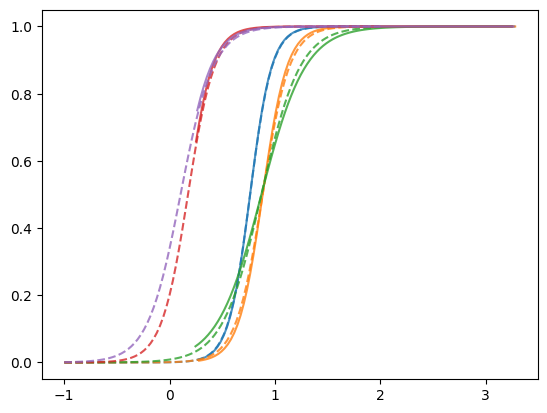

In [4]:
fbm_model = experiment.training_plan().model()
final_params = experiment.aggregated_params()[N_ROUNDS - 1]["params"]

check_model_fit(
    fbm_model.get_k_values(final_params["log_k_values"]).data.numpy(),
    final_params["x0_values"].data.numpy(),
    final_params["time_shifts"].data.numpy(),
    align_x=True,
)

Epoch [100/700], Loss: 258.8777
Epoch [200/700], Loss: -14.4468
Epoch [300/700], Loss: -250.7728
Epoch [400/700], Loss: -412.7839
Epoch [500/700], Loss: -465.9561
Epoch [600/700], Loss: -471.9309
Epoch [700/700], Loss: -472.1648
===== k values =====
[9.601 7.863 5.434 7.895 6.395]
[9.739 8.653 4.771 8.598 6.938]
===== x0 values =====
[0.764 0.883 0.871 0.174 0.104]
[ 0.174  0.285  0.306 -0.395 -0.478]
===== x value differences =====
[0.59  0.598 0.564 0.569 0.581]
===== time shifts =====
[0.927 0.309 0.202 0.303 0.48  0.673 0.743 0.32  0.668 0.303 0.308 0.344
 0.874 0.778 0.841 0.018 0.109 0.49  0.203 0.616 0.945 0.488 0.045 0.791
 0.162 0.71  0.653 0.769 0.485 0.157 0.673 0.041 0.924 0.741 0.062 0.503
 0.184 0.527 0.861 0.467 0.445 0.484 0.625 0.826 0.877 0.422 0.579 0.685
 0.836 0.307]
[ 0.336 -0.259 -0.406 -0.337 -0.161  0.073  0.176 -0.304  0.063 -0.3
 -0.297 -0.28   0.268  0.224  0.235 -0.604 -0.429 -0.142 -0.395 -0.009
  0.367 -0.068 -0.51   0.165 -0.435  0.15   0.075  0.127 -0.1

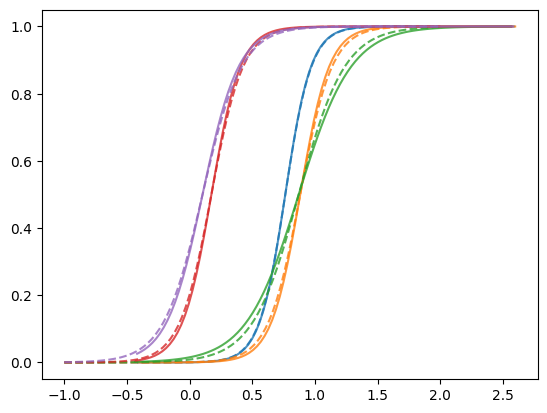

In [4]:
from fl_prog.model import LogisticRegressionModelWithShift
import torch
import torch.optim as optim

model = LogisticRegressionModelWithShift(
    len(set(df["subject"])), n_features=n_biomarkers
)

# Define the optimizer
optimizer = optim.Adam(list(model.parameters()), lr=LEARNING_RATE)

# Optimization loop
num_epochs = (
    N_UPDATES * N_ROUNDS
)  # Increased epochs for potentially harder optimization
for epoch in range(num_epochs):
    # Forward pass
    # Pass both timestamps and sample indices to the model
    model_predictions = model(
        torch.tensor(df["timepoint"]), torch.tensor(df["subject"])
    )
    loss = model.get_loss(
        model_predictions,
        torch.tensor(
            df[[f"biomarker_{i}" for i in range(n_biomarkers)]].values,
        ),
    )

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss periodically
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

check_model_fit(
    model.get_k_values(model.log_k_values).data.numpy(),
    model.x0_values.data.numpy(),
    model.time_shifts.data.numpy(),
    align_x=True,
)